In [1]:
# 创建数据集
import json

X_train = []
y_train = []
X_test = []
y_test = []

with open('IMDB.json','r') as f:
    data = json.load(f)

train_data = data['train']
test_data = data['test']

for item in train_data:
    X_train.append(item['seq'])
    y_train.append(int(item['label']))
    X_test.append(item['seq'])
    y_test.append(int(item['label']))
   
print(f"X_train: {len(X_train)}\ny_train: {len(y_train)}\nX_test: {len(X_test)}\ny_test: {len(y_test)}")
print(f"X_train[0]: {X_train[0][0:100]}\ny_train[0]: {y_train[0]}")

X_train: 25000
y_train: 25000
X_test: 25000
y_test: 25000
X_train[0]: Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life,
y_train[0]: 1


In [2]:
# 清洗数据
import re

def clean_str(string):
    string = string.lower()
    string = re.sub(r"[^a-z\-!?\ ]", "", string)        
    return string

X_train = [clean_str(string) for string in X_train]
X_test = [clean_str(string) for string in X_test]

X_train[0:100]

['bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my  years in the teaching profession lead me to believe that bromwell highs satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled  at  high a classic line inspector im here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isnt!',
 'story of a man who has unnatural feelings for a pig starts out with a opening scene that is a terrific example of absurd comedy a formal orchestra audience is turned into an insane violent mob by the crazy chantings of its singers u

In [3]:
with open('imdb.vocab') as vocab:
    vocab = vocab.readlines()
    vocab = [word.strip() for word in vocab]
    vocab = ['<PAD>'] + vocab

len(vocab), vocab[0:10]

(89528, ['<PAD>', 'the', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i'])

In [4]:
# 构建词典
word2idx = {word:idx for idx, word in enumerate(vocab)}
idx2word = {idx:word for idx, word in enumerate(vocab)}

print(list(word2idx.items())[0:10])

[('<PAD>', 0), ('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('it', 7), ('in', 8), ('i', 9)]


In [5]:
# 进行one-hot编码
encoded_X_train = [[word2idx.get(word, 0) for word in string.split(' ')] for string in X_train]
encoded_X_test = [[word2idx.get(word, 0) for word in string.split(' ')] for string in X_test]

print(f"X_train: {X_train[0:100]}\n")
print(f"encoded_X_train:{encoded_X_train[0:100]}")

X_train: ['bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my  years in the teaching profession lead me to believe that bromwell highs satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled  at  high a classic line inspector im here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isnt!', 'story of a man who has unnatural feelings for a pig starts out with a opening scene that is a terrific example of absurd comedy a formal orchestra audience is turned into an insane violent mob by the crazy chantings of its s

In [6]:
# 数据截断
max_len = 400

encoded_X_train = [string[0:max_len] for string in encoded_X_train]
encoded_X_test = [string[0:max_len] for string in encoded_X_test]

In [7]:
import torch 
from torch import nn

In [8]:
# 对数据进行padding
from torch.nn.utils.rnn import pad_sequence

X_train = pad_sequence([torch.tensor(string) for string in encoded_X_train], batch_first=True)
X_test = pad_sequence([torch.tensor(string) for string in encoded_X_test], batch_first=True)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = torch.tensor(y_train).to(device)
y_test = torch.tensor(y_test).to(device)

device

device(type='cuda')

In [10]:
# 构建数据集
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(X_train, torch.tensor(y_train))
test_data = TensorDataset(X_test, torch.tensor(y_test))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

C:\Users\WJORD\AppData\Local\Temp\ipykernel_27760\1670764787.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = TensorDataset(X_train, torch.tensor(y_train))
C:\Users\WJORD\AppData\Local\Temp\ipykernel_27760\1670764787.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = TensorDataset(X_test, torch.tensor(y_test))


torch.Size([64, 400])
torch.Size([64])


In [11]:
# 构建模型
class IMDBModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes):
        super(IMDBModel, self).__init__()
        
        # 词嵌入层
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # 双向LSTM层
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        
        # 全连接层
        self.fc = nn.Linear(hidden_dim*2, num_classes) # 2是因为是双向的
        
        #Dropout层
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, input_seq):
        # 词嵌入
        embedded_seq = self.embedding(input_seq)

        # 双向LSTM编码
        lstm_output, _ = self.bilstm(embedded_seq)

        # 获取最后一个时间步的输出
        lstm_output = lstm_output[:, -1, :]

        # 使用Dropout层防止过拟合
        lstm_output = self.dropout(lstm_output)

        # 通过全连接层进行分类
        output = self.fc(lstm_output)

        return output
        

In [12]:
# 训练模型
import torch.optim as optim

model = IMDBModel(len(vocab), 128, 128, 2, 2)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10


In [13]:
import matplotlib.pyplot as plt

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, print_every=100, save_path='IMDB_model.pth'):
    best_val_accuracy = 0.0
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(train_loader, 0):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            # 打印训练信息
            if (i + 1) % print_every == 0:
                train_loss = running_loss / print_every
                train_accuracy = 100 * correct_train / total_train
                print(f'Epoch [{epoch+1}/{num_epochs}], Iteration [{i+1}/{len(train_loader)}]')
                print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
                running_loss = 0.0
                correct_train = 0
                total_train = 0

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # 验证模型
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        
        # 如果验证性能优于当前最佳性能，则保存模型
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f'Saved the best model with validation accuracy: {best_val_accuracy:.2f}%')

    # 绘制图像
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

    return train_losses, train_accuracies, val_losses, val_accuracies


Epoch [1/10], Iteration [100/391]
Training Loss: 0.6963, Training Accuracy: 49.61%
Epoch [1/10], Iteration [200/391]
Training Loss: 0.6937, Training Accuracy: 50.38%
Epoch [1/10], Iteration [300/391]
Training Loss: 0.6936, Training Accuracy: 49.75%
Epoch [1/10]
Training Loss: 0.1614, Training Accuracy: 50.52%
Validation Loss: 0.6898, Validation Accuracy: 51.71%
Saved the best model with validation accuracy: 51.71%
Epoch [2/10], Iteration [100/391]
Training Loss: 0.6895, Training Accuracy: 51.34%
Epoch [2/10], Iteration [200/391]
Training Loss: 0.6895, Training Accuracy: 51.41%
Epoch [2/10], Iteration [300/391]
Training Loss: 0.6890, Training Accuracy: 51.14%
Epoch [2/10]
Training Loss: 0.1598, Training Accuracy: 50.86%
Validation Loss: 0.6706, Validation Accuracy: 53.86%
Saved the best model with validation accuracy: 53.86%
Epoch [3/10], Iteration [100/391]
Training Loss: 0.6701, Training Accuracy: 54.58%
Epoch [3/10], Iteration [200/391]
Training Loss: 0.6734, Training Accuracy: 52.58

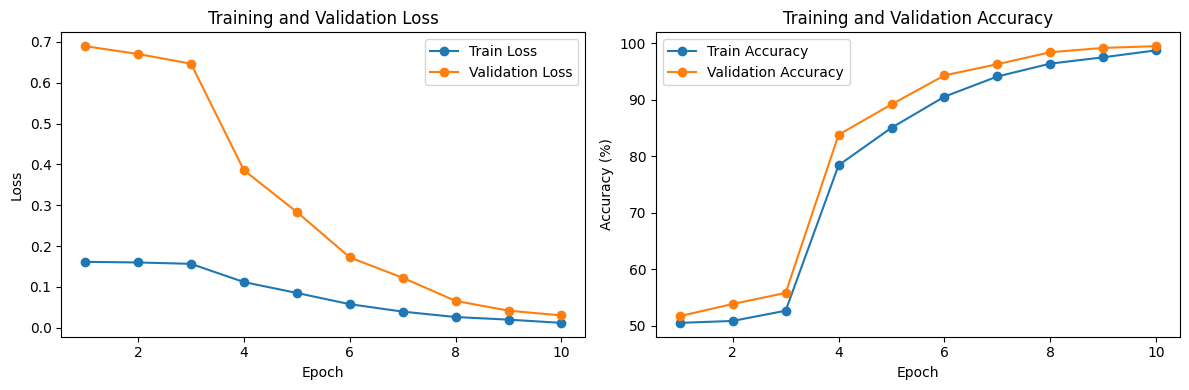

In [14]:
train_losses, train_accuracies, val_losses, val_accuracies = train(model, train_loader, test_loader, loss_fn, optimizer, epochs)